In [1271]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix , classification_report
from sklearn.metrics import roc_curve , auc
from keras.models import Sequential
from keras.layers import Dense
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost
import warnings
warnings.filterwarnings("ignore")

In [1272]:
df = pd.read_pickle('dataset.pkl')
df.head()

,0,1,2,3,4,5,6
0,"[id, 00076211-9BBD-4E06-82C2-E9FB7B102964-750]","[dates, [2017-05-19, 2017-05-29, 2017-05-31, 2...","[transaction_amount, [[-60.0], [0.02], [0.01],...","[days_before_request, [[79.0], [79.0], [76.0],...","[loan_amount, 750]","[loan_date, 2017-08-16]","[isDefault, 1]"
1,"[id, 0009107F-8F57-441C-A590-5773992261A9-500]","[dates, [2017-11-20, 2017-11-20, 2017-11-20, 2...","[transaction_amount, [[-68.93], [-23.7], [-0.5...","[days_before_request, [[12.0], [12.0], [12.0],...","[loan_amount, 500]","[loan_date, 2018-02-17]","[isDefault, 1]"
2,"[id, 000B47CB-514F-446C-B7BE-2F2D304E2F4D-1000]","[dates, [2017-05-29, 2017-05-29, 2017-05-29, 2...","[transaction_amount, [[-23.5], [-9.78], [-14.2...","[days_before_request, [[87.0], [87.0], [87.0],...","[loan_amount, 1000]","[loan_date, 2017-08-25]","[isDefault, 0]"
3,"[id, 000CAC25-AFBD-455D-9367-D23FB38D17B0-250]","[dates, [2017-08-17, 2017-08-17, 2017-08-17, 2...","[transaction_amount, [[-360.0], [105.82], [192...","[days_before_request, [[88.0], [88.0], [88.0],...","[loan_amount, 250]","[loan_date, 2017-11-12]","[isDefault, 0]"
4,"[id, 000E9C38-708E-40F7-8ABC-9DF55B77BB54-500]","[dates, [2016-08-29, 2016-08-29, 2016-08-29, 2...","[transaction_amount, [[-2.16], [-4.96], [-17.4...","[days_before_request, [[88.0], [88.0], [87.0],...","[loan_amount, 500]","[loan_date, 2016-11-25]","[isDefault, 0]"


# Feature_Creation

In [1273]:
#change columns names
df.columns = [['id', 'dates', 'transaction_amount', 'days_before_request', 'loan_amount', 'loan_date', 'isDefault']]
#extract_id
df['id'] = df.iloc[:,0].apply(lambda x : x[1])
#extract_dates
df['dates'] = df.iloc[:,1].apply(lambda x : x[1])
#extract_transaction_amount
df['transaction_amount'] = df.iloc[:,2].apply(lambda x : x[1])
#extract_days
df['days_before_request'] = df.iloc[:,3].apply(lambda x : x[1])
#extract_loan
df['loan_amount'] = df.iloc[:,4].apply(lambda x : x[1])
#extract_date
df['loan_date'] = df.iloc[:,5].apply(lambda x : x[1])


df['transaction_amount'] = df.iloc[:,2].apply(lambda x : np.concatenate(x, axis=0))
df['days_before_request'] = df.iloc[:,3].apply(lambda x : np.concatenate(x, axis=0))

#feature_created
df['max_amount'] = df.iloc[:,2].apply(lambda x : np.max(x))
df['min_amount'] = df.iloc[:,2].apply(lambda x : np.min(x))
df['median_amount'] = df.iloc[:,2].apply(lambda x : np.median(x))
df['mean_amount'] = df.iloc[:,2].apply(lambda x : np.mean(x))

df['max_days'] = df.iloc[:,3].apply(lambda x : np.max(x))
df['min_days'] =  df.iloc[:,3].apply(lambda x : np.min(x))
df['median_days'] = df.iloc[:,3].apply(lambda x : np.median(x))
df['mean_days'] = df.iloc[:,3].apply(lambda x : np.mean(x))

df['loan_date'] = df.loc[:,'loan_date'].apply(lambda x : pd.to_datetime(x))
#reindexing and dropping dates(insignificant feature)

df = df.drop('dates', axis=1)
df.set_index('id', inplace=True)

#getting total no of debit transaction
def num_debit(array):
    n = len(array)
   
    debit=0
    for i in range(0,n):
        if(array[i]>=0):
            debit+=1
      
    return debit     

#total no of credit transaction
def num_credit(array):
    n = len(array)
    
    credit=0
    for i in range(0,n):
        if(array[i]<0):
            credit+=1
      
    return credit   


#all debit values
def debit_values(array):
    n = len(array)
    debit_list = []
    for i in range(0,n):
        if(array[i]>=0):
            debit_list.append(array[i])
      
    return debit_list     
        
 #all credit values

def credit_values(array):
    n = len(array)
    credit_list = []
    for i in range(0,n):
        if(array[i] < 0):
            credit_list.append(array[i])
      
    return credit_list


#getting debit and credit values
df['debit_values'] = df.iloc[:,0].apply(lambda x : np.array(debit_values(x))) 
df['credit_values'] = df.iloc[:,0].apply(lambda x : np.array(credit_values(x)))

#creating features distinguishly for debit and credit transactions

df['debit_min_amount'] = df.iloc[:,13].apply(lambda x : np.min(x) if len(x)>0 else 0)
df['debit_max_amount'] = df.iloc[:,13].apply(lambda x : np.max(x) if len(x)>0 else 0)
df['debit_median_amount'] = df.iloc[:,13].apply(lambda x : np.median(x) if len(x)>0 else 0)
df['debit_mean_amount'] = df.iloc[:,13].apply(lambda x : np.mean(x) if len(x)>0 else 0)

df['credit_min_amount'] = df.iloc[:,14].apply(lambda x : np.min(x) if len(x)>0 else 0)
df['credit_max_amount'] = df.iloc[:,14].apply(lambda x : np.max(x) if len(x)>0 else 0)
df['credit_median_amount'] = df.iloc[:,14].apply(lambda x : np.median(x) if len(x)>0 else 0)
df['credit_mean_amount'] = df.iloc[:,14].apply(lambda x : np.mean(x) if len(x)>0 else 0)




#no of debit and credit data
df['no_debit'] = df.iloc[:,0].apply(lambda x : num_debit(x))
df['no_credit'] = df.iloc[:,0].apply(lambda x : num_credit(x))

#dropping unnecessary features
df = df.drop(['debit_values', 'credit_values','transaction_amount', 'days_before_request', 'loan_date'], axis=1)

In [1274]:
df.head()

,loan_amount,isDefault,max_amount,min_amount,median_amount,mean_amount,max_days,min_days,median_days,mean_days,debit_min_amount,debit_max_amount,debit_median_amount,debit_mean_amount,credit_min_amount,credit_max_amount,credit_median_amount,credit_mean_amount,no_debit,no_credit
id,,,,,,,,,,,,,,,,,,,,
"(00076211-9BBD-4E06-82C2-E9FB7B102964-750,)",750,"[isDefault, 1]",3082.73,-562.00,-32.240,-3.557400,79.0,38.0,52.0,56.300000,0.01,3082.73,60.000,440.055172,-562.00,-0.01,-46.700,-78.789942,29,171
"(0009107F-8F57-441C-A590-5773992261A9-500,)",500,"[isDefault, 1]",1507.26,-1507.26,-3.985,2.387382,89.0,1.0,48.0,44.717277,0.01,1507.26,4.000,178.169900,-1507.26,-0.50,-13.405,-59.946844,100,282
"(000B47CB-514F-446C-B7BE-2F2D304E2F4D-1000,)",1000,"[isDefault, 0]",1639.35,-811.23,-20.330,1.553517,87.0,38.0,62.0,60.059322,20.00,1639.35,783.715,921.300000,-811.23,-0.01,-22.590,-56.448514,14,222
"(000CAC25-AFBD-455D-9367-D23FB38D17B0-250,)",250,"[isDefault, 0]",1000.00,-900.00,-9.990,1.335502,88.0,38.0,66.0,61.510040,0.10,1000.00,30.000,197.990000,-900.00,-0.10,-16.955,-46.844850,49,200
"(000E9C38-708E-40F7-8ABC-9DF55B77BB54-500,)",500,"[isDefault, 0]",806.39,-320.09,-10.010,-1.189833,88.0,38.0,63.5,60.516667,38.90,806.39,215.000,375.659231,-320.09,-0.50,-10.870,-22.771498,13,227


In [1275]:
train_df = df.iloc[0:10000, :]
test_df = df.iloc[10000:,:]
train_df['isDefault'] = train_df.iloc[:,1].apply(lambda x : x[1])

In [1276]:
train_df.head()

,loan_amount,isDefault,max_amount,min_amount,median_amount,mean_amount,max_days,min_days,median_days,mean_days,debit_min_amount,debit_max_amount,debit_median_amount,debit_mean_amount,credit_min_amount,credit_max_amount,credit_median_amount,credit_mean_amount,no_debit,no_credit
id,,,,,,,,,,,,,,,,,,,,
"(00076211-9BBD-4E06-82C2-E9FB7B102964-750,)",750,1,3082.73,-562.00,-32.240,-3.557400,79.0,38.0,52.0,56.300000,0.01,3082.73,60.000,440.055172,-562.00,-0.01,-46.700,-78.789942,29,171
"(0009107F-8F57-441C-A590-5773992261A9-500,)",500,1,1507.26,-1507.26,-3.985,2.387382,89.0,1.0,48.0,44.717277,0.01,1507.26,4.000,178.169900,-1507.26,-0.50,-13.405,-59.946844,100,282
"(000B47CB-514F-446C-B7BE-2F2D304E2F4D-1000,)",1000,0,1639.35,-811.23,-20.330,1.553517,87.0,38.0,62.0,60.059322,20.00,1639.35,783.715,921.300000,-811.23,-0.01,-22.590,-56.448514,14,222
"(000CAC25-AFBD-455D-9367-D23FB38D17B0-250,)",250,0,1000.00,-900.00,-9.990,1.335502,88.0,38.0,66.0,61.510040,0.10,1000.00,30.000,197.990000,-900.00,-0.10,-16.955,-46.844850,49,200
"(000E9C38-708E-40F7-8ABC-9DF55B77BB54-500,)",500,0,806.39,-320.09,-10.010,-1.189833,88.0,38.0,63.5,60.516667,38.90,806.39,215.000,375.659231,-320.09,-0.50,-10.870,-22.771498,13,227


# Preprocessing

In [1362]:
# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()
# apply le on categorical feature columns


X = train_df.drop('isDefault', axis=1)
y = train_df['isDefault']


In [1363]:
#Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#Scale Data
sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_train=pd.DataFrame(X_train,columns=X.columns)
X_test=sc.transform(X_test)



# Models 

              precision    recall  f1-score   support

           0       0.76      0.92      0.84      1494
           1       0.42      0.16      0.23       506

    accuracy                           0.73      2000
   macro avg       0.59      0.54      0.53      2000
weighted avg       0.68      0.73      0.68      2000



Text(91.68, 0.5, 'predicted label')

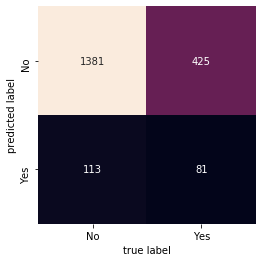

In [1364]:
#Apply RandomForest Algorethm
random_classifier= RandomForestClassifier()
random_classifier.fit(X_train,y_train)
y_pred= random_classifier.predict(X_test)

#Classification Report
print(classification_report(y_test,y_pred))

#Confusion Matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')


In [1365]:
TN=mat[0,0]
TP=mat[1,1]
FN=mat[1,0]
FP=mat[0,1]
sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)

In [1366]:
print('The acuuracy of the model = TP+TN/(TP+TN+FP+FN) = ',(TP+TN)/float(TP+TN+FP+FN),'\n',

'The Missclassification = 1-Accuracy = ',1-((TP+TN)/float(TP+TN+FP+FN)),'\n',

'Sensitivity or True Positive Rate = TP/(TP+FN) = ',TP/float(TP+FN),'\n',

'Specificity or True Negative Rate = TN/(TN+FP) = ',TN/float(TN+FP),'\n',

'Positive Predictive value = TP/(TP+FP) = ',TP/float(TP+FP),'\n',

'Negative predictive Value = TN/(TN+FN) = ',TN/float(TN+FN),'\n',

'Positive Likelihood Ratio = Sensitivity/(1-Specificity) = ',sensitivity/(1-specificity),'\n',

'Negative likelihood Ratio = (1-Sensitivity)/Specificity = ',(1-sensitivity)/specificity)

The acuuracy of the model = TP+TN/(TP+TN+FP+FN) =  0.731 
 The Missclassification = 1-Accuracy =  0.269 
 Sensitivity or True Positive Rate = TP/(TP+FN) =  0.1600790513833992 
 Specificity or True Negative Rate = TN/(TN+FP) =  0.9243641231593038 
 Positive Predictive value = TP/(TP+FP) =  0.4175257731958763 
 Negative predictive Value = TN/(TN+FN) =  0.7646733111849391 
 Positive Likelihood Ratio = Sensitivity/(1-Specificity) =  2.1164433873167985 
 Negative likelihood Ratio = (1-Sensitivity)/Specificity =  0.9086472825729194


In [1367]:
#get features Importances
xx= pd.Series(random_classifier.feature_importances_,index=X.columns)
xx.sort_values(ascending=False)

median_amount           0.074036
credit_mean_amount      0.069416
mean_amount             0.067527
credit_median_amount    0.066816
debit_median_amount     0.065038
no_credit               0.062114
debit_mean_amount       0.060353
no_debit                0.059808
debit_max_amount        0.056974
mean_days               0.056808
max_amount              0.055536
loan_amount             0.054295
credit_min_amount       0.053189
min_amount              0.051055
credit_max_amount       0.048692
debit_min_amount        0.046400
max_days                0.023893
median_days             0.023830
min_days                0.004221
dtype: float64

# Other Models

In [1368]:
y_test = y_test.values.reshape(-1)

In [1369]:
X_test.shape

(2000, 19)

In [1370]:
classifiers = [['DecisionTree :',DecisionTreeClassifier()],
               ['RandomForest :',RandomForestClassifier()], 
               ['Naive Bayes :', GaussianNB()],
               ['KNeighbours :', KNeighborsClassifier()],
               ['SVM :', SVC()],
               ['Neural Network :', MLPClassifier()],
               ['LogisticRegression :', LogisticRegression()],
               ['ExtraTreesClassifier :', ExtraTreesClassifier()],
               ['AdaBoostClassifier :', AdaBoostClassifier()],
               ['GradientBoostingClassifier: ', GradientBoostingClassifier()]]

predictions_df = pd.DataFrame()
predictions_df['actual_labels'] = y_test

for name,classifier in classifiers:
    classifier = classifier
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    predictions_df[name.strip(" :")] = predictions
    print(name, accuracy_score(y_test, predictions))

DecisionTree : 0.6575
RandomForest : 0.7195
Naive Bayes : 0.5705
KNeighbours : 0.7005
SVM : 0.753
Neural Network : 0.7415
LogisticRegression : 0.749
ExtraTreesClassifier : 0.73
AdaBoostClassifier : 0.751
GradientBoostingClassifier:  0.753


In [1371]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(class_weight={0:.4, 1:.6})
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

In [1372]:
#Checking Differner Thresholds.

In [1373]:
pred_proba_df = pd.DataFrame(logreg.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(y_test.reshape(y_test.size,1),
                                           Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1))
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(y_test.reshape(y_test.size,1),
                           Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1)))


******** For i = 0.05 ******
Our testing accuracy is 0.254
[[   2 1492]
 [   0  506]]

******** For i = 0.1 ******
Our testing accuracy is 0.2575
[[  10 1484]
 [   1  505]]

******** For i = 0.15 ******
Our testing accuracy is 0.284
[[  67 1427]
 [   5  501]]

******** For i = 0.2 ******
Our testing accuracy is 0.3365
[[ 180 1314]
 [  13  493]]

******** For i = 0.25 ******
Our testing accuracy is 0.4205
[[ 370 1124]
 [  35  471]]

******** For i = 0.3 ******
Our testing accuracy is 0.5105
[[602 892]
 [ 87 419]]

******** For i = 0.35 ******
Our testing accuracy is 0.6
[[863 631]
 [169 337]]

******** For i = 0.4 ******
Our testing accuracy is 0.6675
[[1082  412]
 [ 253  253]]

******** For i = 0.45 ******
Our testing accuracy is 0.703
[[1235  259]
 [ 335  171]]

******** For i = 0.5 ******
Our testing accuracy is 0.729
[[1346  148]
 [ 394  112]]

******** For i = 0.55 ******
Our testing accuracy is 0.7425
[[1413   81]
 [ 434   72]]

******** For i = 0.6 ******
Our testing accuracy is

In [1374]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.729

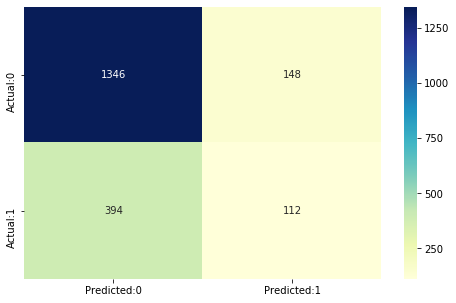

In [1375]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [1376]:
TN=cm[0,0]
TP=cm[1,1]
FN=cm[1,0]
FP=cm[0,1]
sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)

In [1377]:
print('The acuuracy of the model = TP+TN/(TP+TN+FP+FN) = ',(TP+TN)/float(TP+TN+FP+FN),'\n',

'The Missclassification = 1-Accuracy = ',1-((TP+TN)/float(TP+TN+FP+FN)),'\n',

'Sensitivity or True Positive Rate = TP/(TP+FN) = ',TP/float(TP+FN),'\n',

'Specificity or True Negative Rate = TN/(TN+FP) = ',TN/float(TN+FP),'\n',

'Positive Predictive value = TP/(TP+FP) = ',TP/float(TP+FP),'\n',

'Negative predictive Value = TN/(TN+FN) = ',TN/float(TN+FN),'\n',

'Positive Likelihood Ratio = Sensitivity/(1-Specificity) = ',sensitivity/(1-specificity),'\n',

'Negative likelihood Ratio = (1-Sensitivity)/Specificity = ',(1-sensitivity)/specificity)

The acuuracy of the model = TP+TN/(TP+TN+FP+FN) =  0.729 
 The Missclassification = 1-Accuracy =  0.271 
 Sensitivity or True Positive Rate = TP/(TP+FN) =  0.22134387351778656 
 Specificity or True Negative Rate = TN/(TN+FP) =  0.9009370816599732 
 Positive Predictive value = TP/(TP+FP) =  0.4307692307692308 
 Negative predictive Value = TN/(TN+FN) =  0.7735632183908046 
 Positive Likelihood Ratio = Sensitivity/(1-Specificity) =  2.2343766691592775 
 Negative likelihood Ratio = (1-Sensitivity)/Specificity =  0.8642735906125013


In [1378]:
y_pred_prob=logreg.predict_proba(X_test)[:,:]
y_pred_prob_df=pd.DataFrame(data=y_pred_prob, columns=['Prob of no Default','Prob of Default'])
y_pred_prob_df.head()

,Prob of no Default,Prob of Default
0,0.759121,0.240879
1,0.795566,0.204434
2,0.726790,0.273210
3,0.764025,0.235975
4,0.675876,0.324124


# Prediction

In [1379]:
X_test_data = test_df.drop('isDefault', axis=1)
index = X_test_data.index
X_test_data=sc.transform(X_test_data)
Predictions =logreg.predict_proba(X_test_data)[:,:]
Predictions_df =pd.DataFrame(data=Predictions, columns=['Prob of no Default','Prob of Default'], index=index)
Predictions_df.head()


,Prob of no Default,Prob of Default
id,,
"(A9C3F4CA-66BF-44EE-8C38-1C50D0751CD1-500,)",0.475195,0.524805
"(A9C93D6B-8625-48EE-9E05-EB63256DEEA6-500,)",0.592443,0.407557
"(A9D12F62-35D5-44DE-8446-B8C2E4A5E938-750,)",0.721035,0.278965
"(A9D3EC9F-B3EB-4A56-8BC6-4614A1C42FE2-600,)",0.711630,0.288370
"(A9D54EF9-3CBA-4481-80B2-59FD92BB60D9-700,)",0.728665,0.271335


In [1380]:
Final_Submission = Predictions_df.drop('Prob of no Default', axis=1)
Final_Submission.head()


,Prob of Default
id,
"(A9C3F4CA-66BF-44EE-8C38-1C50D0751CD1-500,)",0.524805
"(A9C93D6B-8625-48EE-9E05-EB63256DEEA6-500,)",0.407557
"(A9D12F62-35D5-44DE-8446-B8C2E4A5E938-750,)",0.278965
"(A9D3EC9F-B3EB-4A56-8BC6-4614A1C42FE2-600,)",0.288370
"(A9D54EF9-3CBA-4481-80B2-59FD92BB60D9-700,)",0.271335


In [1381]:
Final_Submission_CSV = Final_Submission.to_csv()